# new Najafi-Golestanian

This is a rerun of `src_30`, but 100 ticks between $t = 10,000~\mu \mathrm{s}$ and $t = 10T$, where $T = 25~\mu \mathrm{s}$ is the period of the swimmer.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd
import copy
import auxiliary as aux

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

%reload_ext autoreload
%autoreload 2

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
src_n = 30
dataDir = f'../data.lbm/{src_n}/'
# dataDir = f'../src/{src_n}/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dataDir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

101

# Fluid

In [7]:
id = -1
fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[id]}.csv").set_index(["id_x","id_y"]).sort_index()
particleDf = pd.read_csv(dataDir+"particlesTrj.csv")

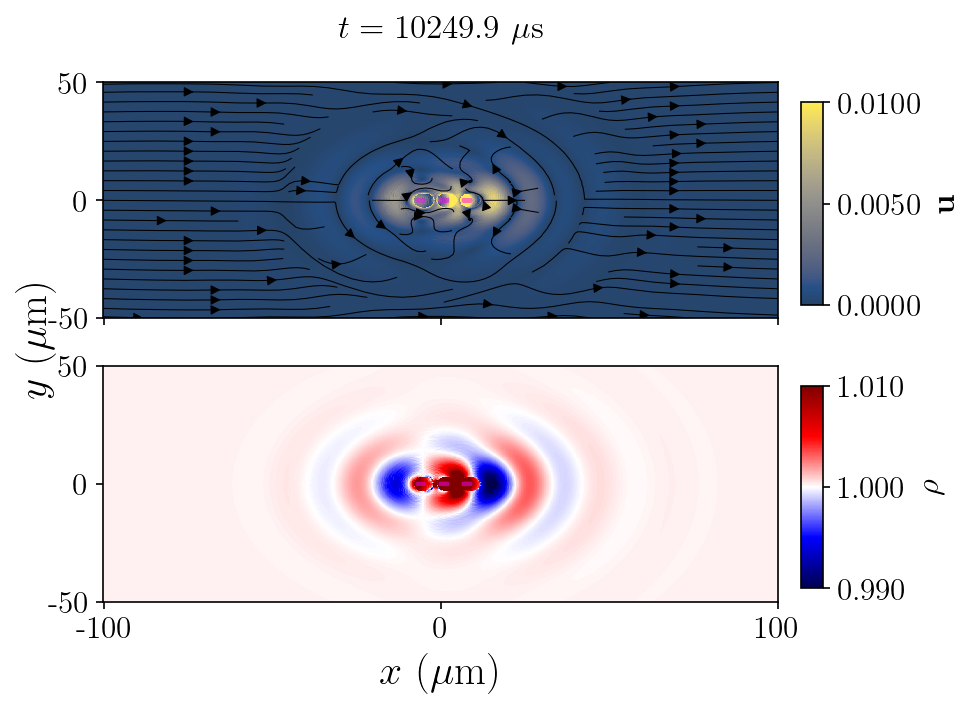

In [5]:
title = f'$t = {fluidDf.time.values[-1]:0.1f}$'+' $\\mu \\mathrm{s}$'
# fig, axes = aux.fluidOverview(fluidDf, particleDf, title)
fig, axes = aux.fluidOverview(
    fluidDf.query("coordinate_y**2<=50**2"),
    particleDf, 
    title,
    maxFluidSpeed = 1e-2,
    massDensityEpsilon = 1e-2,
)
plt.show()

# particles

In [6]:
nParticles = len(particleDf.particleId.unique())
particleTime = particleDf.time.unique()
particleSpeed = np.sqrt(
    particleDf.query(f"particleId == {1}").velocity_x.values**2 + 
    particleDf.query(f"particleId == {1}").velocity_y.values**2
)
period = 25
periodId = np.argmin((particleTime - period)**2)
particleAvgSpeed = np.asarray([particleSpeed[max(0,Id - periodId):Id+1].mean() for Id in np.arange(len(particleSpeed))])

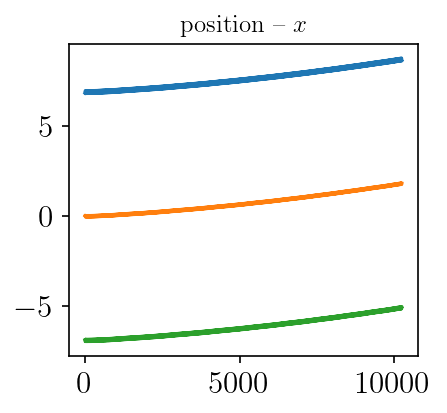

In [7]:
# fig, axes = plt.subplots(1,2,figsize=(6,2.7))
fig, axes = plt.subplots(figsize=(3,2.7))

for Id in np.arange(nParticles):
    axes.plot(particleTime, particleDf.query(f"particleId == {Id+1}").position_x.values, )
axes.set_title("position -- $x$")
# axes[0].set_xlim(20000-100,20000)
# axes[0].set_ylim(40-10,40+10)
    
# for Id in np.arange(nParticles):
#     particleSpeed = np.sqrt(
#         particleDf.query(f"particleId == {Id+1}").velocity_x.values**2 + 
#         particleDf.query(f"particleId == {Id+1}").velocity_y.values**2
#     )
#     axes[1].plot(particleTime, 
#         np.asarray([particleSpeed[max(0,Id - periodId):Id+1].mean() for Id in np.arange(len(particleSpeed))])
#     )
# axes[1].set_title("speed -- $|\\mathbf{u}|$")
# # axes[1].set_ylim(0,1e-3)
# axes[1].yaxis.tick_right()  # Moves y-axis ticks to the right
# # axes[1].set_yticks([0, 0.5e-3, 1e-3])
# # axes[1].set_yticklabels(["0", "", "$10^{-3}$"])
    
plt.show()

# Mean fluid velocity analysis

In [5]:
periodsSaved = 10
ticksSaved = 100
tickPeriod = int(round(ticksSaved/periodsSaved))
halfPeriod = int(round(tickPeriod/2))

In [ ]:
# auxTicks = n:n+tickPeriod+1
n = 1
print(n, end="")
print('... ', end="")
meanFluid = pd.read_csv(dataDir + f"fluidTrj_{ticks[n]}.csv").set_index(["id_x","id_y"]).sort_index()
meanFluid = meanFluid[[
    'tick', 'time',
    'coordinate_x',
    'coordinate_y',
    'massDensity',
    'fluidVelocity_x',
    'fluidVelocity_y'
]]
for Id in np.arange(n+1,n+tickPeriod):
    print(Id, end="")
    print('... ', end="")
    auxDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[Id]}.csv").set_index(["id_x","id_y"]).sort_index()
    meanFluid['massDensity'] += auxDf['massDensity']
    meanFluid['fluidVelocity_x'] += auxDf['fluidVelocity_x']
    meanFluid['fluidVelocity_y'] += auxDf['fluidVelocity_y']

meanFluid['massDensity'] /= tickPeriod
meanFluid['fluidVelocity_x'] /= tickPeriod
meanFluid['fluidVelocity_y'] /= tickPeriod

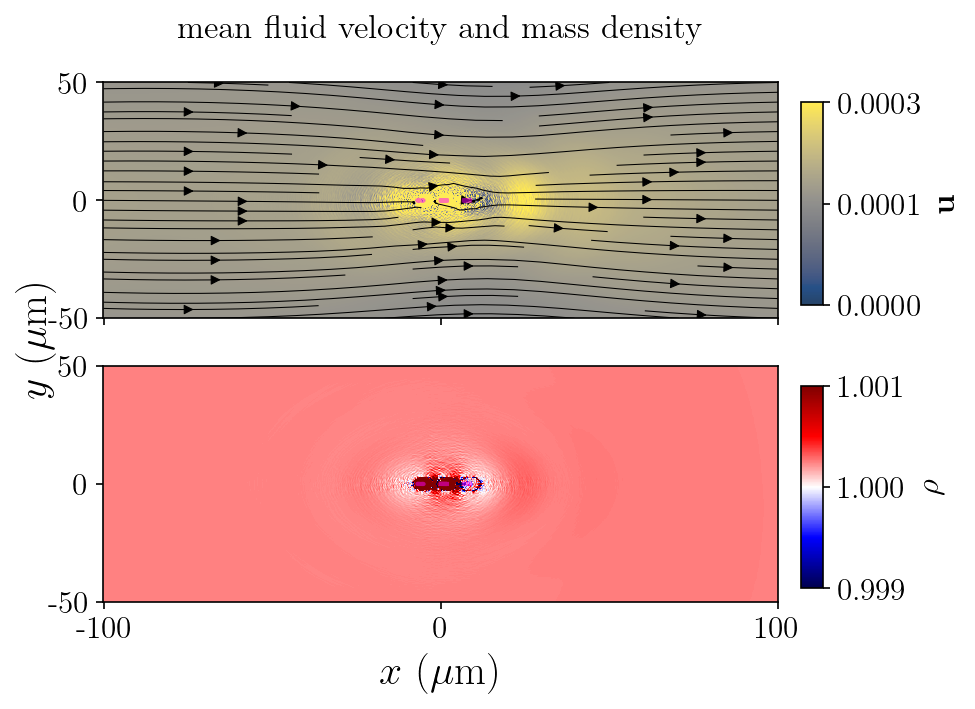

In [13]:
fig, axes = aux.fluidOverview(
    meanFluid.query("coordinate_y**2<=50**2"),
    particleDf, 
    'mean fluid velocity and mass density',
    maxFluidSpeed = 3e-4,
    massDensityEpsilon = 1e-3,
)
plt.show()

1... 2... 3... 4... 5... 

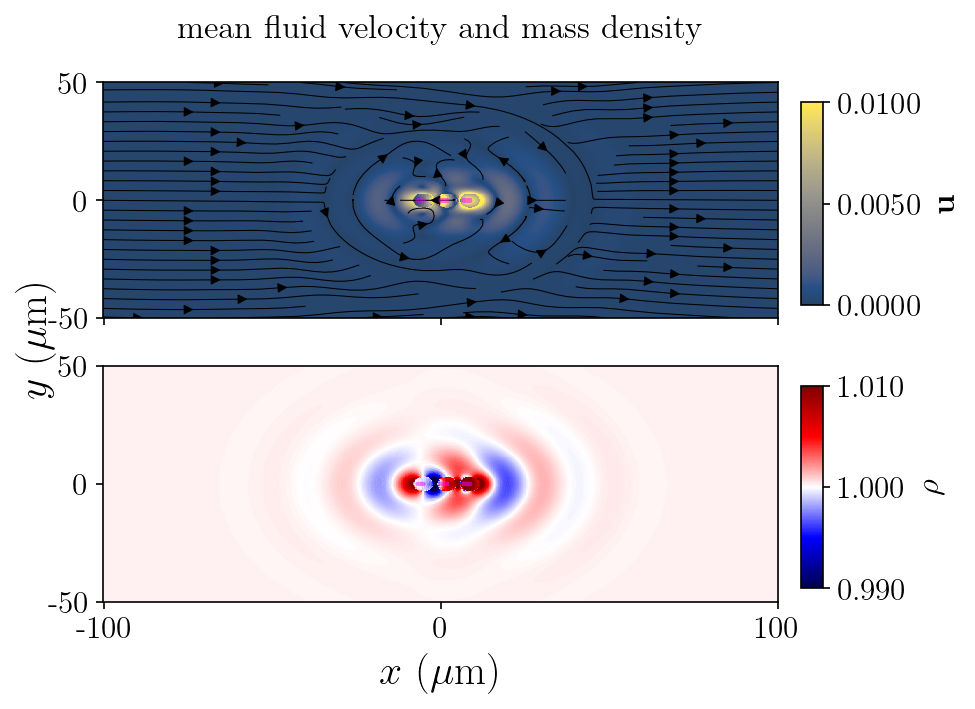

In [9]:
# auxTicks = n:n+tickPeriod+1
n = 1
print(n, end="")
print('... ', end="")
meanFluid = pd.read_csv(dataDir + f"fluidTrj_{ticks[n]}.csv").set_index(["id_x","id_y"]).sort_index()
meanFluid = meanFluid[[
    'tick', 'time',
    'coordinate_x',
    'coordinate_y',
    'massDensity',
    'fluidVelocity_x',
    'fluidVelocity_y'
]]
for Id in np.arange(n+1,n+halfPeriod):
    print(Id, end="")
    print('... ', end="")
    auxDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[Id]}.csv").set_index(["id_x","id_y"]).sort_index()
    meanFluid['massDensity'] += auxDf['massDensity']
    meanFluid['fluidVelocity_x'] += auxDf['fluidVelocity_x']
    meanFluid['fluidVelocity_y'] += auxDf['fluidVelocity_y']

meanFluid['massDensity'] /= halfPeriod
meanFluid['fluidVelocity_x'] /= halfPeriod
meanFluid['fluidVelocity_y'] /= halfPeriod

fig, axes = aux.fluidOverview(
    meanFluid.query("coordinate_y**2<=50**2"),
    particleDf, 
    'mean fluid velocity and mass density',
    maxFluidSpeed = 1e-2,
    massDensityEpsilon = 1e-2,
)
plt.show()

6... 7... 8... 9... 10... 

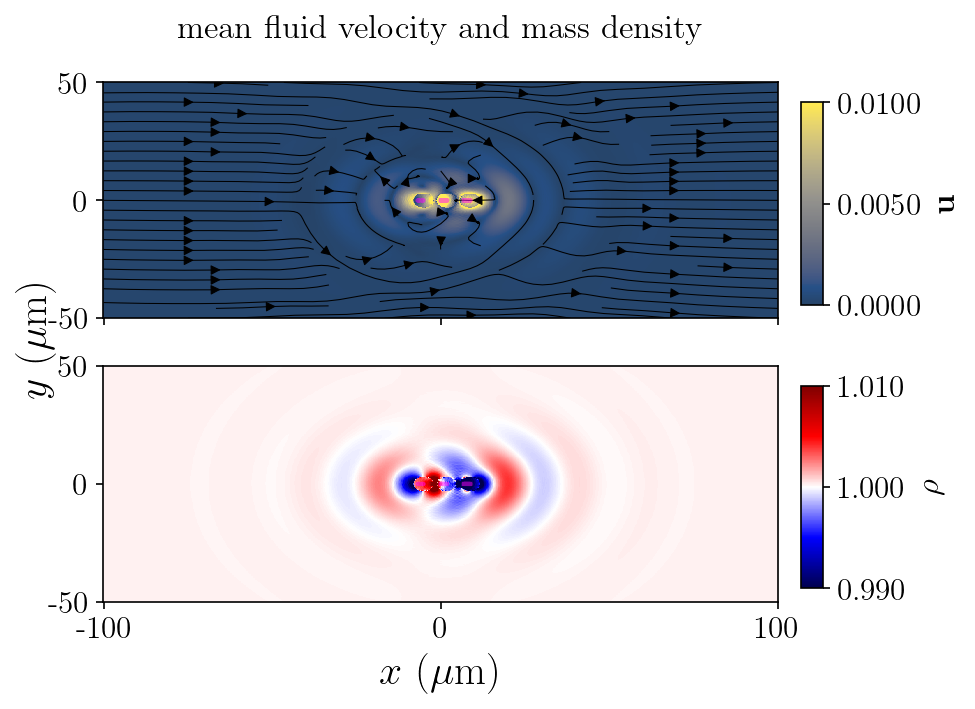

In [10]:
# auxTicks = n:n+tickPeriod+1
n = halfPeriod+1
print(n, end="")
print('... ', end="")
meanFluid = pd.read_csv(dataDir + f"fluidTrj_{ticks[n]}.csv").set_index(["id_x","id_y"]).sort_index()
meanFluid = meanFluid[[
    'tick', 'time',
    'coordinate_x',
    'coordinate_y',
    'massDensity',
    'fluidVelocity_x',
    'fluidVelocity_y'
]]
for Id in np.arange(n+1,n+halfPeriod):
    print(Id, end="")
    print('... ', end="")
    auxDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[Id]}.csv").set_index(["id_x","id_y"]).sort_index()
    meanFluid['massDensity'] += auxDf['massDensity']
    meanFluid['fluidVelocity_x'] += auxDf['fluidVelocity_x']
    meanFluid['fluidVelocity_y'] += auxDf['fluidVelocity_y']

meanFluid['massDensity'] /= halfPeriod
meanFluid['fluidVelocity_x'] /= halfPeriod
meanFluid['fluidVelocity_y'] /= halfPeriod

fig, axes = aux.fluidOverview(
    meanFluid.query("coordinate_y**2<=50**2"),
    particleDf, 
    'mean fluid velocity and mass density',
    maxFluidSpeed = 1e-2,
    massDensityEpsilon = 1e-2,
)
plt.show()

# stability analysis

In [12]:
def avgSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).mean()

In [13]:
try:
    avgFluidSpeed 
except NameError:
    avgFluidSpeed = []
    
try:
    time 
except NameError:
    time = []

for tick in ticks[len(time)::]:
    auxDf = pd.read_csv(dataDir + f"fluidTrj_{tick}.csv")
    avgFluidSpeed.append(avgSpeed(auxDf))
    time.append(auxDf.time.values[0])
    print(f'\r{tick}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

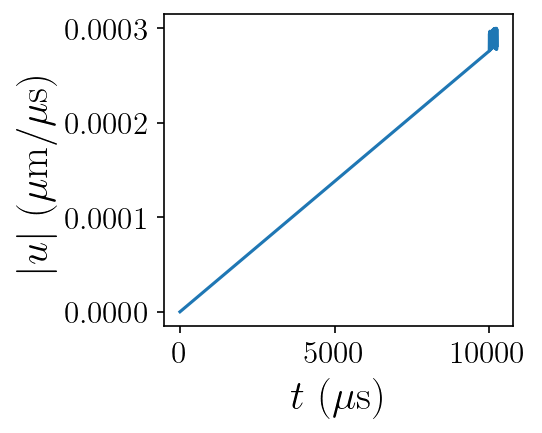

In [14]:
fig, ax = plt.subplots(figsize=(3,2.7))

ax.plot(time, avgFluidSpeed)
ax.set_xlabel("$t ~ (\\mu \\mathrm{s})$")
ax.set_ylabel("$|u| ~ (\\mu \\mathrm{m} / \\mu \\mathrm{s})$")

plt.show()

# Animation

In [15]:
# necessary directories are created
outputDir = f"frames.{src_n}"
os.system(f'mkdir -p anims')
os.system(f'mkdir {outputDir}')

# the data is read and frames are saved
particleDf = pd.read_csv(dataDir+"particlesTrj.csv")
for tickId in np.arange(len(ticks)):
    fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[tickId]}.csv").set_index(["id_x","id_y"]).sort_index()
    title = f'$t = {fluidDf.time.values[-1]:.0f}$'+' $\\mu \\mathrm{s}$'
    fig, axes = aux.fluidOverview(
        fluidDf.query("coordinate_y**2<=50**2"),
        particleDf, 
        title,
        maxFluidSpeed = 1e-2,
        massDensityEpsilon = 1e-2,
    )

    plt.savefig(f"{outputDir}/{tickId}.png", format="png", dpi=300, bbox_inches="tight")
    plt.close()
    print(f'\r{tickId}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

# ffmpeg is used to create the animation
mkAnimSh = f'ffmpeg -framerate 20 -i {outputDir}/%d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -pix_fmt yuv420p -loglevel quiet anims/src_{src_n}.mp4'
os.system(mkAnimSh)

# the directory with the frames is erased
os.system(f'rm -r {outputDir}')

0